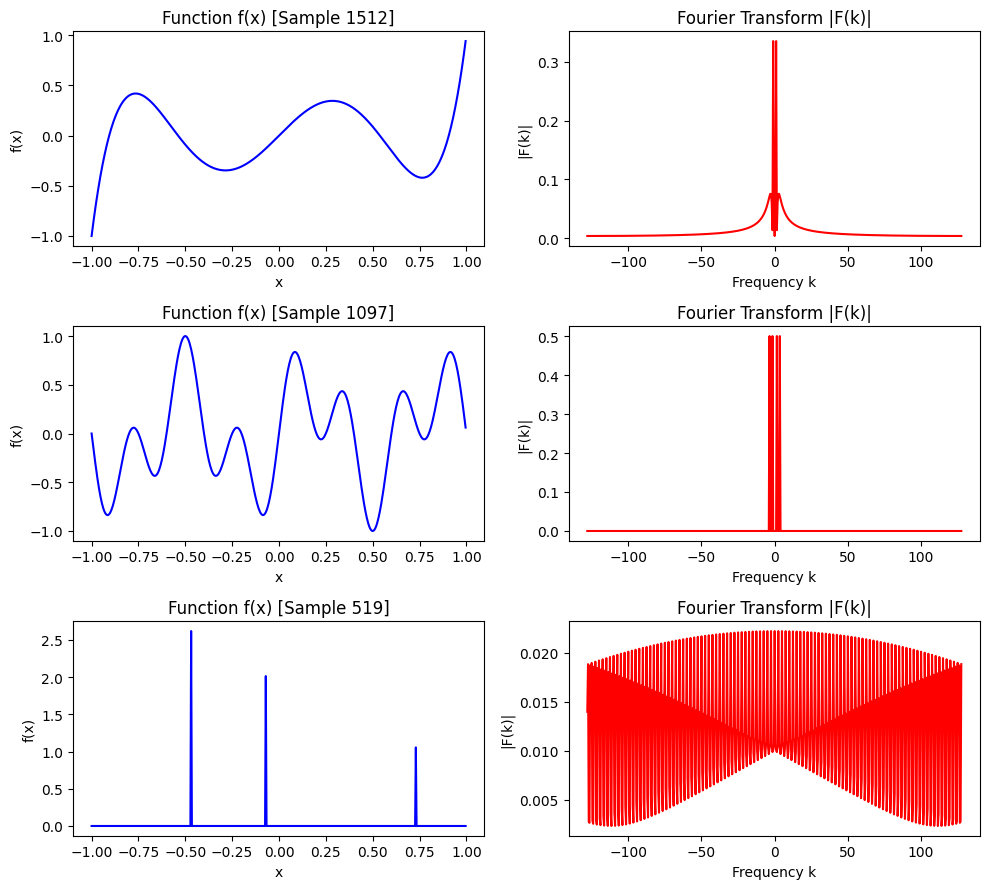

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Reuse dataset generator from before
import numpy as np
from scipy.special import legendre, chebyt, jv, hermite, eval_laguerre

def make_function(x, kind="random", max_freq=10):
    """
    Generate a diverse set of functions for Fourier testing.

    Parameters:
        x        : array of input points
        kind     : type of function to generate; if 'random', one is picked randomly
        max_freq : maximum frequency for Fourier-type functions

    Returns:
        f        : array of function values
    """
    
    if kind == "random":
        kind = np.random.choice([
            "fourier", "poly", "gaussian", "gaussian_mixture",
            "damped_sine", "exp_decay", "piecewise", "trig_combo",
            "legendre", "chebyshev", "bessel",
            "hermite", "laguerre",
            "windowed_sine", "rect_pulse", "sawtooth", "triangle",
            "modulated", "chirp", "spikes", "wavelet"
        ])
    
    # ----------------- Standard types -----------------
    if kind == "fourier":
        coeffs = np.random.randn(max_freq)
        f = np.zeros_like(x, dtype=float)
        for n, a in enumerate(coeffs, start=1):
            f += a * np.sin(np.pi * n * x)
        return f

    elif kind == "poly":
        coeffs = np.random.randn(5)
        return sum(c * x**i for i, c in enumerate(coeffs))

    elif kind == "gaussian":
        mu, sigma = np.random.uniform(-0.5, 0.5), np.random.uniform(0.05, 0.5)
        return np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

    elif kind == "gaussian_mixture":
        num_gaussians = np.random.randint(2, 4)
        f = np.zeros_like(x)
        for _ in range(num_gaussians):
            mu, sigma, amp = np.random.uniform(-0.5,0.5), np.random.uniform(0.05,0.3), np.random.uniform(0.5,2.0)
            f += amp * np.exp(-((x - mu)**2) / (2 * sigma**2))
        return f

    elif kind == "damped_sine":
        freq = np.random.uniform(1, max_freq)
        decay = np.random.uniform(0.5, 2.0)
        phase = np.random.uniform(0, 2*np.pi)
        return np.exp(-decay * np.abs(x)) * np.sin(2 * np.pi * freq * x + phase)

    elif kind == "exp_decay":
        lam = np.random.uniform(0.5, 2.0)
        return np.exp(-lam * np.abs(x))

    elif kind == "piecewise":
        split = np.random.uniform(x[0], x[-1])
        return np.piecewise(x, [x < split, x >= split],
                            [lambda t: t**2, lambda t: -t + split])

    elif kind == "trig_combo":
        f = np.zeros_like(x)
        num_terms = np.random.randint(2, 5)
        for _ in range(num_terms):
            amp = np.random.uniform(0.5, 2.0)
            freq = np.random.randint(1, max_freq)
            phase = np.random.uniform(0, 2*np.pi)
            f += amp * (np.sin(2*np.pi*freq*x + phase) + np.cos(2*np.pi*freq*x + phase))
        return f

    # ----------------- Special polynomials -----------------
    elif kind == "legendre":
        deg = np.random.randint(1, 6)
        P = legendre(deg)
        return P(x)

    elif kind == "chebyshev":
        deg = np.random.randint(1, 6)
        T = chebyt(deg)
        return T(x)

    elif kind == "bessel":
        order = np.random.randint(0, 6)
        k = np.random.uniform(1, 10)
        return jv(order, k * x)

    elif kind == "hermite":
        deg = np.random.randint(1,5)
        H = hermite(deg)
        return H(x)

    elif kind == "laguerre":
        deg = np.random.randint(1,5)
        return eval_laguerre(deg, np.abs(x))  # Laguerre defined on [0,∞)

    # ----------------- Windowed / localized functions -----------------
    elif kind == "windowed_sine":
        freq = np.random.uniform(1, max_freq)
        alpha = np.random.uniform(1,5)
        return np.sin(2*np.pi*freq*x) * np.exp(-alpha*x**2)

    elif kind == "rect_pulse":
        start, end = np.random.uniform(-0.5, 0), np.random.uniform(0,0.5)
        return np.where((x>=start) & (x<=end), 1.0, 0.0)

    elif kind == "sawtooth":
        return 2*(x - np.floor(x + 0.5))  # normalized sawtooth

    elif kind == "triangle":
        return 2*np.abs(2*(x - np.floor(x + 0.5))) - 1

    elif kind == "modulated":
        f1 = np.sin(5*np.pi*x)
        f2 = np.cos(2*np.pi*x)
        return f1*f2

    elif kind == "chirp":
        return np.sin(2*np.pi*(x + x**2))

    elif kind == "spikes":
        f = np.zeros_like(x)
        num_spikes = np.random.randint(3,8)
        indices = np.random.choice(len(x), num_spikes, replace=False)
        f[indices] = np.random.uniform(1,3, size=num_spikes)
        return f

    elif kind == "wavelet":
        return (1 - x**2) * np.exp(-x**2 / 2)  # Mexican hat

    else:
        raise ValueError(f"Unknown function type '{kind}'")

# List of all available function types
function_types = [
    "fourier",          # sum of sinusoids
    "poly",             # standard polynomial
    "gaussian",         # single Gaussian
    "gaussian_mixture", # sum of Gaussians
    "damped_sine",      # exponentially damped sinusoid
    "exp_decay",        # exponential decay
    "piecewise",        # piecewise linear/quadratic
    "trig_combo",       # combination of sin and cos
    "legendre",         # Legendre polynomials
    "chebyshev",        # Chebyshev polynomials (1st kind)
    "bessel",           # Bessel function of first kind
    "hermite",          # Hermite polynomials
    "laguerre",         # Laguerre polynomials
    "windowed_sine",    # sinusoid multiplied by Gaussian
    "rect_pulse",       # rectangular pulse
    "sawtooth",         # sawtooth wave
    "triangle",         # triangle wave
    "modulated",        # product of sinusoids (beats)
    "chirp",            # frequency-increasing sinusoid
    "spikes",           # sparse impulses
    "wavelet"           # Mexican hat wavelet
]


def generate_dataset(num_samples, N, domain):
    x = np.linspace(domain[0], domain[1], N, endpoint=False)
    dx = x[1] - x[0]
    freqs = np.fft.fftfreq(N, d=dx)

    data_f = []
    data_F = []

    for _ in range(num_samples):
        kind = np.random.choice(function_types)
        f = make_function(x, kind=kind)
        F = np.fft.fft(f) * dx
        F = np.fft.fftshift(F)
        freqs_shifted = np.fft.fftshift(freqs)

        data_f.append(f.astype(np.float32))
        data_F.append(np.stack([F.real, F.imag], axis=-1).astype(np.float32))
    
    return np.array(data_f), np.array(data_F), freqs_shifted, x



# --- Generate dataset ---
num_samples = 2000
N = 512 #discretization
domain = (-1,1)
f_data, F_data, k_grid, x_grid = generate_dataset(num_samples, N, domain)

# --- Plot some random samples ---
num_plots = 3
indices = np.random.choice(len(f_data), num_plots, replace=False)

fig, axes = plt.subplots(num_plots, 2, figsize=(10, 3*num_plots))

for i, idx in enumerate(indices):
    f = f_data[idx]
    F = F_data[idx]
    F_mag = np.sqrt(F[:,0]**2 + F[:,1]**2)  # magnitude

    axes[i,0].plot(x_grid, f, color='b')
    axes[i,0].set_title(f"Function f(x) [Sample {idx}]")
    axes[i,0].set_xlabel("x")
    axes[i,0].set_ylabel("f(x)")

    axes[i,1].plot(k_grid, F_mag, color='r')
    axes[i,1].set_title("Fourier Transform |F(k)|")
    axes[i,1].set_xlabel("Frequency k")
    axes[i,1].set_ylabel("|F(k)|")

plt.tight_layout()
plt.show()

In [2]:
#seperate networks for real and imaginary
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

train_frac = 0.8
split_idx = int(train_frac*len(f_data))

f_train, f_test = f_data[:split_idx], f_data[split_idx:]
F_train, F_test = F_data[:split_idx], F_data[split_idx:]

# Split real and imag
F_train_real, F_train_imag = F_train[...,0], F_train[...,1]
F_test_real, F_test_imag = F_test[...,0], F_test[...,1]

batch_size = 32
train_loader_real = DataLoader(TensorDataset(torch.tensor(f_train), torch.tensor(F_train_real)), batch_size=batch_size, shuffle=True)
train_loader_imag = DataLoader(TensorDataset(torch.tensor(f_train), torch.tensor(F_train_imag)), batch_size=batch_size, shuffle=True)
test_loader_real = DataLoader(TensorDataset(torch.tensor(f_test), torch.tensor(F_test_real)), batch_size=batch_size)
test_loader_imag = DataLoader(TensorDataset(torch.tensor(f_test), torch.tensor(F_test_imag)), batch_size=batch_size)

# -------------------------
# Neural network for one part
# -------------------------
class FourierNetPart(nn.Module):
    def __init__(self, N):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(N, N*2),
            nn.ReLU(),
            nn.Linear(N*2, N*2),
            nn.ReLU(),
            nn.Linear(N*2, N)
        )
        self.N = N

    def forward(self, x):
        return self.model(x)

# -------------------------
# Instantiate networks
# -------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
model_real = FourierNetPart(N).to(device)
model_imag = FourierNetPart(N).to(device)

criterion = nn.MSELoss()
optimizer_real = optim.Adam(model_real.parameters(), lr=1e-3)
optimizer_imag = optim.Adam(model_imag.parameters(), lr=1e-3)

# -------------------------
# Training loop
# -------------------------
epochs = 50
for epoch in range(epochs):
    # Real
    model_real.train()
    total_loss_real = 0
    for xb, yb in train_loader_real:
        xb, yb = xb.to(device), yb.to(device)
        optimizer_real.zero_grad()
        pred = model_real(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer_real.step()
        total_loss_real += loss.item()*xb.size(0)
    avg_loss_real = total_loss_real/len(train_loader_real.dataset)

    # Imag
    model_imag.train()
    total_loss_imag = 0
    for xb, yb in train_loader_imag:
        xb, yb = xb.to(device), yb.to(device)
        optimizer_imag.zero_grad()
        pred = model_imag(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer_imag.step()
        total_loss_imag += loss.item()*xb.size(0)
    avg_loss_imag = total_loss_imag/len(train_loader_imag.dataset)

    print(f"Epoch {epoch+1}/{epochs}, Loss Real: {avg_loss_real:.6f}, Loss Imag: {avg_loss_imag:.6f}")

# -------------------------
# Inference
# -------------------------
model_real.eval()
model_imag.eval()
with torch.no_grad():
    xb = torch.tensor(f_test, dtype=torch.float32).to(device)
    F_pred_real = model_real(xb).cpu().numpy()
    F_pred_imag = model_imag(xb).cpu().numpy()

F_pred = np.stack([F_pred_real,F_pred_imag],axis=-1)

Epoch 1/50, Loss Real: 0.007634, Loss Imag: 0.004454
Epoch 2/50, Loss Real: 0.001906, Loss Imag: 0.002110
Epoch 3/50, Loss Real: 0.001106, Loss Imag: 0.001353
Epoch 4/50, Loss Real: 0.001800, Loss Imag: 0.001016
Epoch 5/50, Loss Real: 0.000676, Loss Imag: 0.000913
Epoch 6/50, Loss Real: 0.000558, Loss Imag: 0.000815
Epoch 7/50, Loss Real: 0.000864, Loss Imag: 0.000694
Epoch 8/50, Loss Real: 0.000890, Loss Imag: 0.000654
Epoch 9/50, Loss Real: 0.000742, Loss Imag: 0.000456
Epoch 10/50, Loss Real: 0.000589, Loss Imag: 0.000528
Epoch 11/50, Loss Real: 0.000334, Loss Imag: 0.000545
Epoch 12/50, Loss Real: 0.000338, Loss Imag: 0.000394
Epoch 13/50, Loss Real: 0.000434, Loss Imag: 0.000403
Epoch 14/50, Loss Real: 0.000206, Loss Imag: 0.000386
Epoch 15/50, Loss Real: 0.000165, Loss Imag: 0.000367
Epoch 16/50, Loss Real: 0.000173, Loss Imag: 0.000333
Epoch 17/50, Loss Real: 0.000193, Loss Imag: 0.000361
Epoch 18/50, Loss Real: 0.000286, Loss Imag: 0.000560
Epoch 19/50, Loss Real: 0.000179, Los

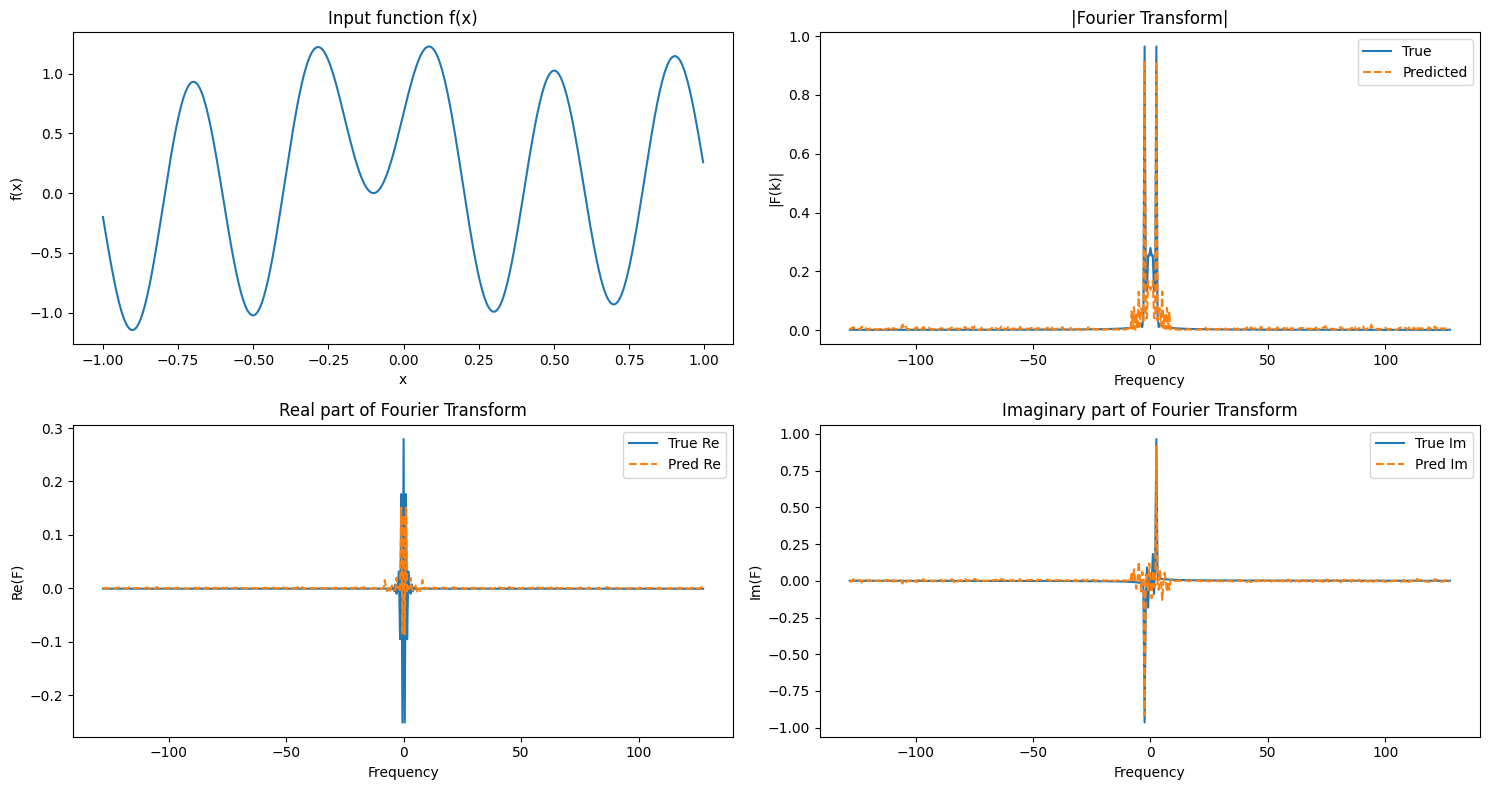

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def test_function(func, model_real, model_imag, N=512, domain=(-1,1)):
    """
    Test a neural network model that predicts Fourier transforms.
    
    Parameters:
        func  : function
            Function f(x) to be transformed
        model : PyTorch model
            Trained neural network model
        N     : int
            Number of points
        domain: tuple
            Interval over which function is defined
            
    Returns:
        x       : array
            Sample points
        f       : array
            Function values at x
        freqs   : array
            Frequency components
        F       : array
            True Fourier transform of f
        F_pred  : array
            Predicted Fourier transform from model
    """
    # Discretize domain
    x = np.linspace(domain[0], domain[1], N, endpoint=False)
    dx = x[1] - x[0]

    # Evaluate function
    f = func(x)

    # True Fourier transform using FFT
    F = np.fft.fft(f) * dx
    F = np.fft.fftshift(F)

    # Frequency components
    freqs = np.fft.fftfreq(N, d=dx)
    freqs = np.fft.fftshift(freqs)
    
    # Convert to tensor and pass through model
    f_tensor = torch.tensor(f.astype(np.float32)).unsqueeze(0).to(device)
    with torch.no_grad():
        pred_real = model_real(f_tensor).cpu().numpy()[0]
    with torch.no_grad():
        pred_imag = model_imag(f_tensor).cpu().numpy()[0]

    # Combine predicted real and imaginary parts
    F_pred = pred_real[:] + 1j*pred_imag[:]

    return x, f, freqs, F, F_pred

# -------------------------
# Example usage: test on a polynomial
# -------------------------
# Assume 'model' is already defined and trained
x, f, k, F_true, F_pred = test_function(lambda x: np.sin(5*np.pi*x) + np.exp(-40*(x+0.1)**2) + 0.2*x**3, model_real, model_imag)

# Plot results
plt.figure(figsize=(15,8))

# -------------------
# Top row
# -------------------
plt.subplot(2,2,1)
plt.plot(x, f)
plt.title("Input function f(x)")
plt.xlabel("x")
plt.ylabel("f(x)")

plt.subplot(2,2,2)
plt.plot(k, np.abs(F_true), label="True")
plt.plot(k, np.abs(F_pred), '--', label="Predicted")
plt.title("|Fourier Transform|")
plt.xlabel("Frequency")
plt.ylabel("|F(k)|")
plt.legend()

# -------------------
# Bottom row
# -------------------
plt.subplot(2,2,3)
plt.plot(k, F_true.real, label="True Re")
plt.plot(k, F_pred.real, '--', label="Pred Re")
plt.title("Real part of Fourier Transform")
plt.xlabel("Frequency")
plt.ylabel("Re(F)")
plt.legend()

plt.subplot(2,2,4)
plt.plot(k, F_true.imag, label="True Im")
plt.plot(k, F_pred.imag, '--', label="Pred Im")
plt.title("Imaginary part of Fourier Transform")
plt.xlabel("Frequency")
plt.ylabel("Im(F)")
plt.legend()

plt.tight_layout()
plt.show()